In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

#Login

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Create Data

In [0]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, size, dim = 2):
        # Load Data 
        self.x_train = np.random.random_sample((1, size, dim))
        
        self.y_train = np.ones((1, size))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Train GAN

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 8
hidden_size = 32
data_dim = 2
num_epochs = 10000
batch_size = 1

# Discriminator
D = nn.Sequential(
    nn.Linear(data_dim, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, data_dim),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [0]:
def train_gan(data_loader, D, G, num_epochs, data_dim, criterion, d_optimizer, g_optimizer, laatent_size, hidden_size, batch_size, device, z_pool = False, z_pool_size = 5000):  
    g_loss_list = []
    e = []
    d_loss_real_list = []
    d_loss_fake_list = []
    total_step = len(data_loader)

    if z_pool:
        latent_vector_pool = np.random.random_sample((z_pool_size, latent_size))

    for epoch in range(num_epochs):
        e.append(epoch)
        for i, (data_point, _) in enumerate(data_loader):
            data_point = data_point.reshape(batch_size, -1).to(device)
            # Create the labels which are later used as input for the BCE loss
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(data_point.float())
            d_loss_real = criterion(outputs, real_labels)
            if i == total_step - 1:
                d_loss_real_list.append(d_loss_real)
            real_score = outputs
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0

            if not z_pool:
                z = torch.randn(batch_size, latent_size).to(device)
            else:
                z_idx = np.random.randint(z_pool_size, size = batch_size)
                z = torch.from_numpy(latent_vector_pool[z_idx]).float().to(device)

            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            if i == total_step - 1:
                d_loss_fake_list.append(d_loss_fake)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            # Compute loss with fake images
            if not z_pool:
                z = torch.randn(batch_size, latent_size).to(device)
            else:
                z_idx = np.random.randint(z_pool_size, size = batch_size)
                z = torch.from_numpy(latent_vector_pool[z_idx]).float().to(device)

            fake_images = G(z)
            outputs = D(fake_images)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels)
            if i == total_step - 1:
                g_loss_list.append(g_loss)

            # Backprop and optimize
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                      .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                              real_score.mean().item(), fake_score.mean().item()))
        
        
            # Print State of the GAN
            if epoch % 10000 == 0:
                print("The current data point is {}".format(data_point))
                print("The current prediction is {}".format(fake_images))

        if epoch % 10000 == 0:
            plt.plot(e, d_loss_real_list, 'b-', label = 'd_loss_real')
            plt.plot(e, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
            plt.plot(e, g_loss_list, 'r-', label = 'g_loss')
            plt.legend()
            plt.show()

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.9947, 0.8601]], device='cuda:0', grad_fn=<TanhBackward>)


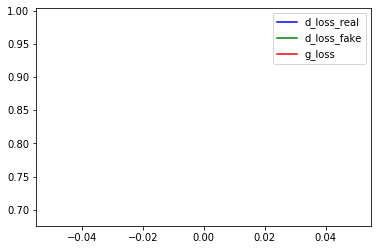

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.2268, 0.2823]], device='cuda:0', grad_fn=<TanhBackward>)


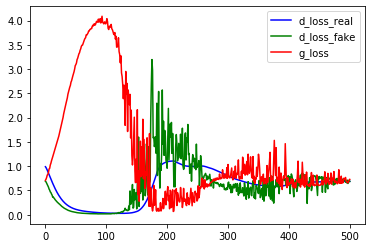

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.0733, 0.0807]], device='cuda:0', grad_fn=<TanhBackward>)


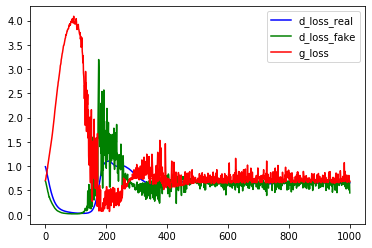

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.0957, 0.0949]], device='cuda:0', grad_fn=<TanhBackward>)


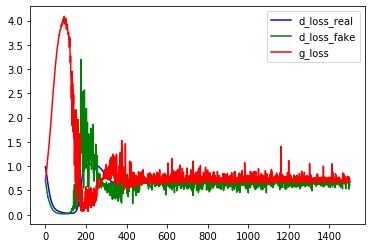

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1024, 0.1090]], device='cuda:0', grad_fn=<TanhBackward>)


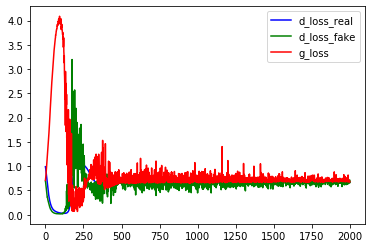

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.0933, 0.0905]], device='cuda:0', grad_fn=<TanhBackward>)


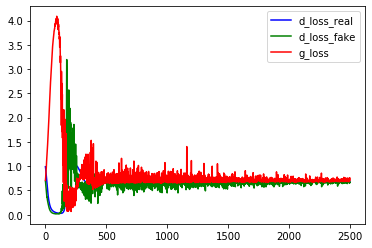

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1188, 0.1213]], device='cuda:0', grad_fn=<TanhBackward>)


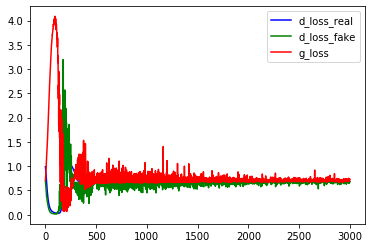

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1079, 0.1050]], device='cuda:0', grad_fn=<TanhBackward>)


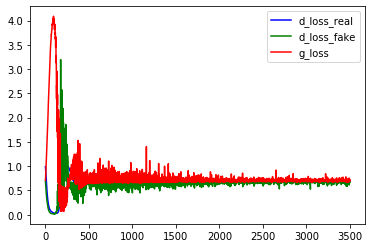

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1192, 0.1082]], device='cuda:0', grad_fn=<TanhBackward>)


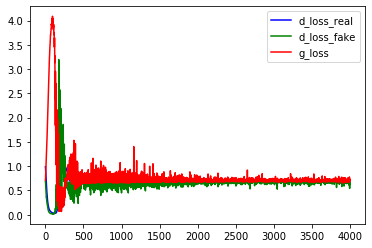

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1092, 0.1038]], device='cuda:0', grad_fn=<TanhBackward>)


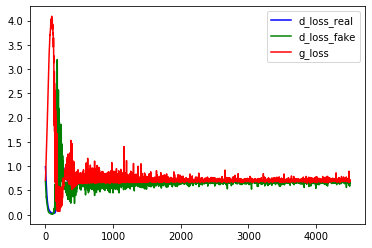

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.0995, 0.0979]], device='cuda:0', grad_fn=<TanhBackward>)


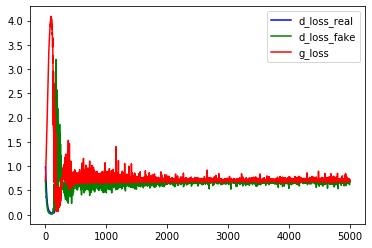

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1037, 0.1049]], device='cuda:0', grad_fn=<TanhBackward>)


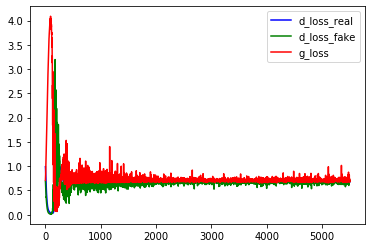

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1091, 0.1027]], device='cuda:0', grad_fn=<TanhBackward>)


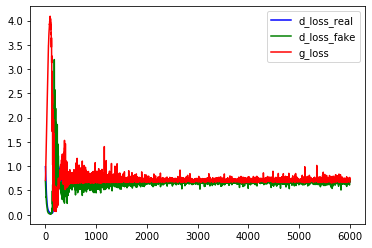

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1119, 0.1060]], device='cuda:0', grad_fn=<TanhBackward>)


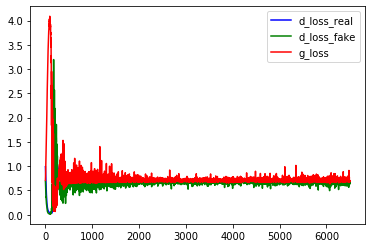

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1090, 0.1106]], device='cuda:0', grad_fn=<TanhBackward>)


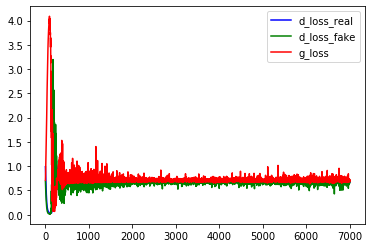

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.0803, 0.0783]], device='cuda:0', grad_fn=<TanhBackward>)


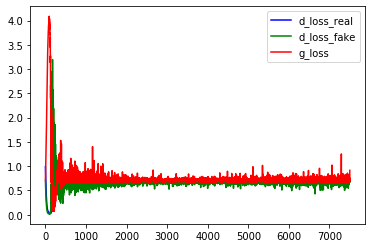

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1118, 0.1040]], device='cuda:0', grad_fn=<TanhBackward>)


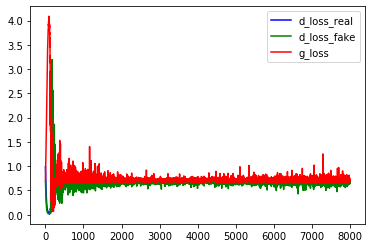

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1102, 0.1064]], device='cuda:0', grad_fn=<TanhBackward>)


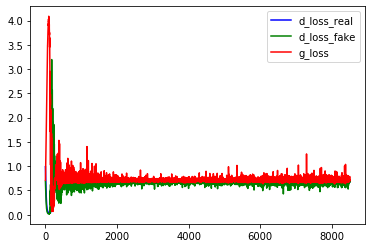

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1095, 0.1084]], device='cuda:0', grad_fn=<TanhBackward>)


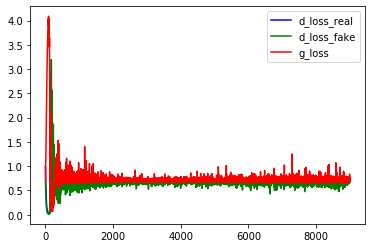

The current data point is tensor([[0.1070, 0.1024]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1152, 0.1058]], device='cuda:0', grad_fn=<TanhBackward>)


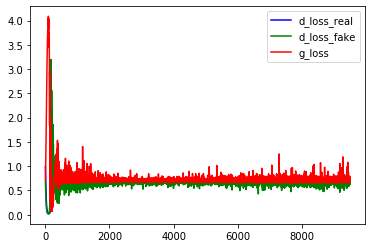

In [34]:
dataset = ToyDataset(1, 2)

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1, 
                                           shuffle=True)

train_gan(data_loader, D, G, num_epochs, data_dim, criterion, d_optimizer, g_optimizer, latent_size, hidden_size, batch_size, device)

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.0279, 0.7393]], device='cuda:0', grad_fn=<TanhBackward>)


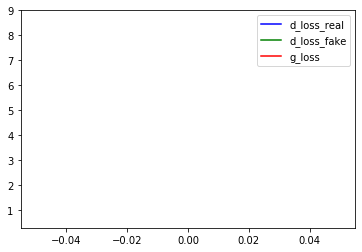

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1526, 0.1266]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1659, 0.1120]], device='cuda:0', grad_fn=<TanhBackward>)


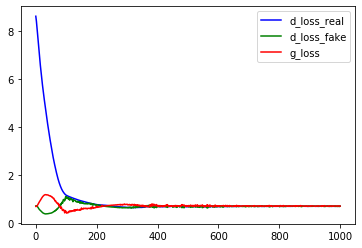

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1626, 0.1132]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1584, 0.1059]], device='cuda:0', grad_fn=<TanhBackward>)


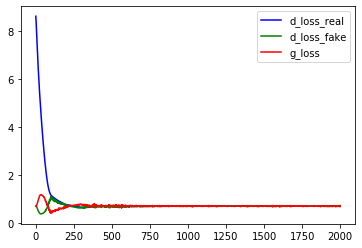

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1610, 0.1089]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1637, 0.1132]], device='cuda:0', grad_fn=<TanhBackward>)


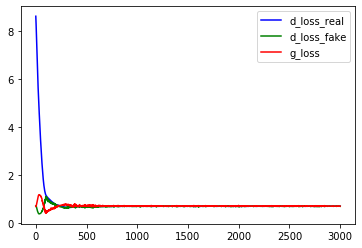

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1622, 0.1135]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1644, 0.1095]], device='cuda:0', grad_fn=<TanhBackward>)


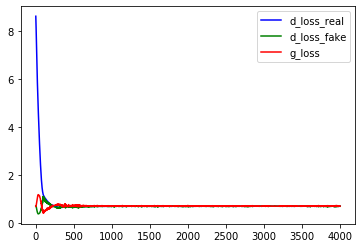

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1576, 0.1172]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1646, 0.1117]], device='cuda:0', grad_fn=<TanhBackward>)


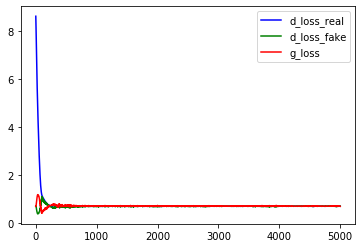

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1633, 0.1090]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1631, 0.1098]], device='cuda:0', grad_fn=<TanhBackward>)


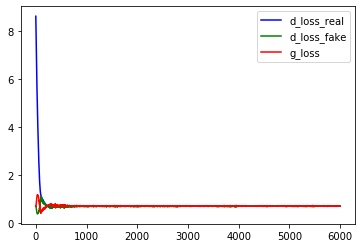

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1572, 0.1160]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1650, 0.1104]], device='cuda:0', grad_fn=<TanhBackward>)


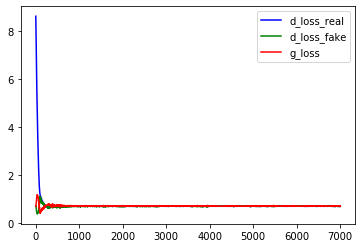

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1659, 0.1136]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1643, 0.1104]], device='cuda:0', grad_fn=<TanhBackward>)


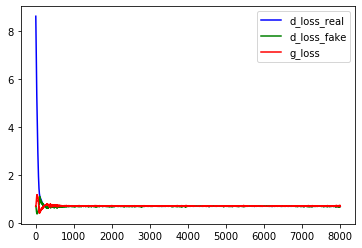

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1646, 0.1124]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1661, 0.1076]], device='cuda:0', grad_fn=<TanhBackward>)


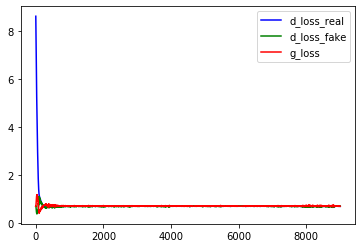

The current data point is tensor([[0.1646, 0.1106]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1559, 0.1190]], device='cuda:0', grad_fn=<TanhBackward>)


In [43]:
dataset = ToyDataset(1, 2)

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1, 
                                           shuffle=True)

train_gan(data_loader, D, G, num_epochs, data_dim, criterion, d_optimizer, g_optimizer, latent_size, hidden_size, batch_size, device, z_pool = True, z_pool_size = 10000)

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.1637, 0.1124]], device='cuda:0', grad_fn=<TanhBackward>)


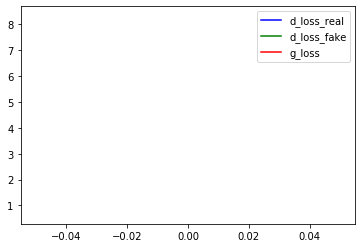

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.8610, 0.0082]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7934, 0.1151]], device='cuda:0', grad_fn=<TanhBackward>)


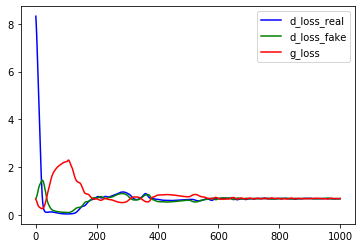

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7861, 0.1158]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7869, 0.1161]], device='cuda:0', grad_fn=<TanhBackward>)


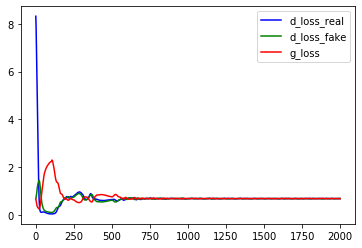

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7883, 0.1178]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7974, 0.1202]], device='cuda:0', grad_fn=<TanhBackward>)


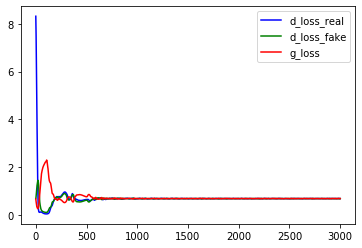

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7895, 0.1192]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7925, 0.1187]], device='cuda:0', grad_fn=<TanhBackward>)


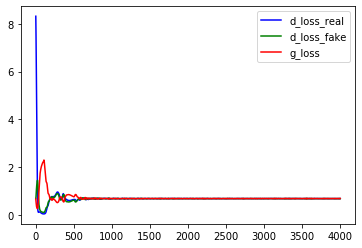

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7955, 0.1184]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7973, 0.1180]], device='cuda:0', grad_fn=<TanhBackward>)


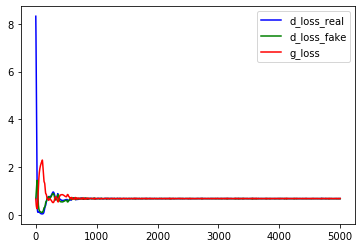

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7939, 0.1208]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7920, 0.1205]], device='cuda:0', grad_fn=<TanhBackward>)


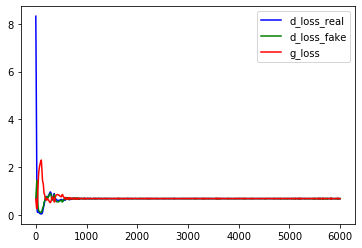

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7932, 0.1198]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7948, 0.1196]], device='cuda:0', grad_fn=<TanhBackward>)


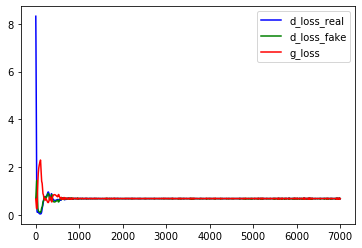

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7948, 0.1188]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7964, 0.1190]], device='cuda:0', grad_fn=<TanhBackward>)


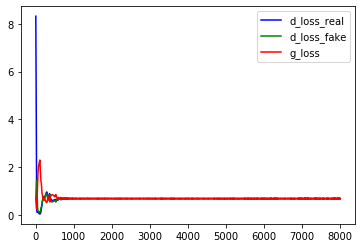

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7936, 0.1213]], device='cuda:0', grad_fn=<TanhBackward>)
The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7972, 0.1206]], device='cuda:0', grad_fn=<TanhBackward>)


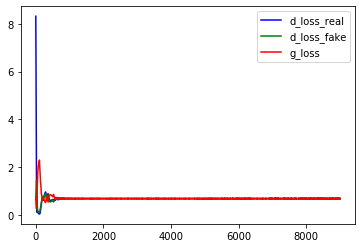

The current data point is tensor([[0.7951, 0.1196]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.7947, 0.1197]], device='cuda:0', grad_fn=<TanhBackward>)


In [44]:
dataset = ToyDataset(1, 2)

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1, 
                                           shuffle=True)

train_gan(data_loader, D, G, num_epochs, data_dim, criterion, d_optimizer, g_optimizer, latent_size, hidden_size, batch_size, device, z_pool = True, z_pool_size = 1)

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.5484, 0.3507]], device='cuda:0', grad_fn=<TanhBackward>)


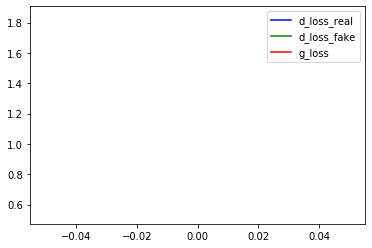

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3095, 0.8862]], device='cuda:0', grad_fn=<TanhBackward>)


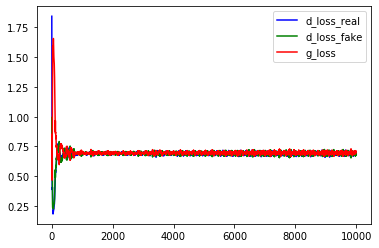

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3116, 0.8893]], device='cuda:0', grad_fn=<TanhBackward>)


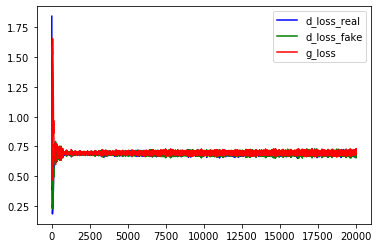

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3137, 0.8942]], device='cuda:0', grad_fn=<TanhBackward>)


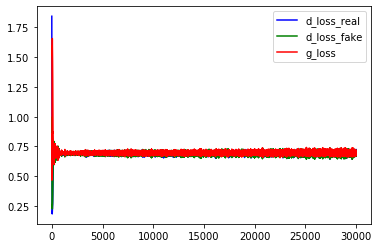

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3020, 0.8745]], device='cuda:0', grad_fn=<TanhBackward>)


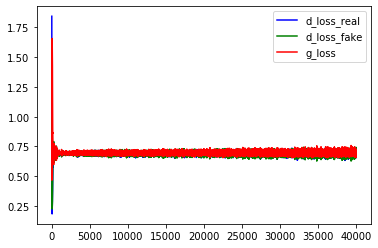

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3116, 0.8885]], device='cuda:0', grad_fn=<TanhBackward>)


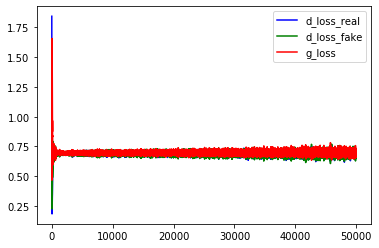

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3159, 0.8954]], device='cuda:0', grad_fn=<TanhBackward>)


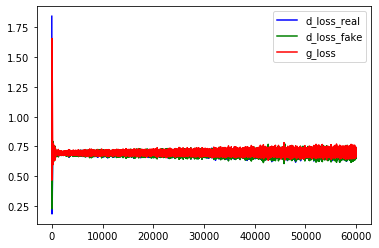

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3160, 0.8946]], device='cuda:0', grad_fn=<TanhBackward>)


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


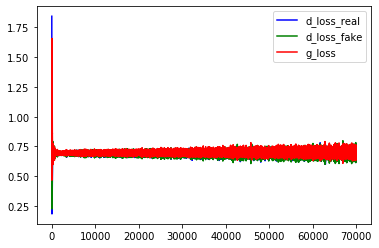

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3083, 0.8853]], device='cuda:0', grad_fn=<TanhBackward>)


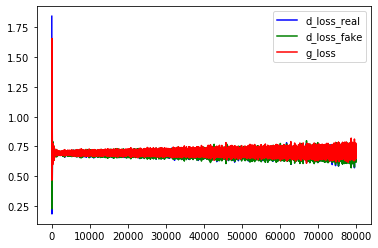

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3132, 0.8932]], device='cuda:0', grad_fn=<TanhBackward>)


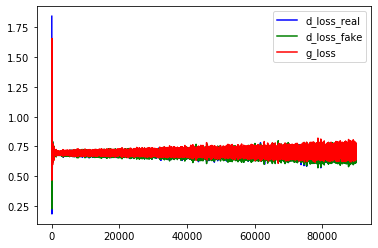

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3060, 0.8791]], device='cuda:0', grad_fn=<TanhBackward>)


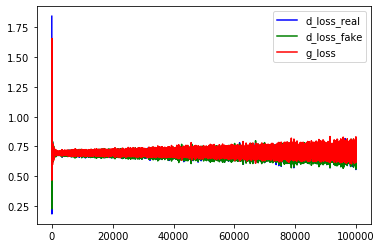

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3066, 0.8826]], device='cuda:0', grad_fn=<TanhBackward>)


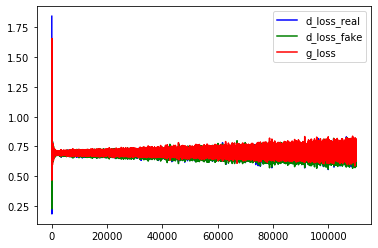

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3108, 0.8853]], device='cuda:0', grad_fn=<TanhBackward>)


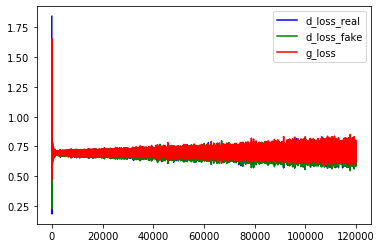

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3029, 0.8784]], device='cuda:0', grad_fn=<TanhBackward>)


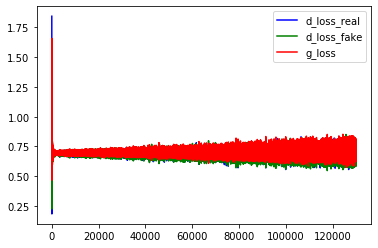

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3104, 0.8880]], device='cuda:0', grad_fn=<TanhBackward>)


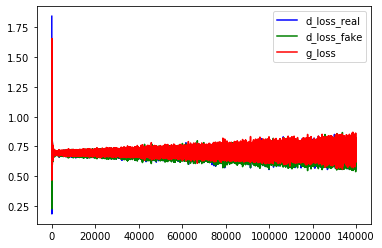

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3125, 0.8893]], device='cuda:0', grad_fn=<TanhBackward>)


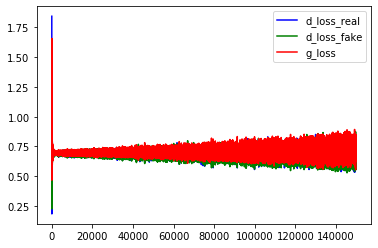

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3038, 0.8784]], device='cuda:0', grad_fn=<TanhBackward>)


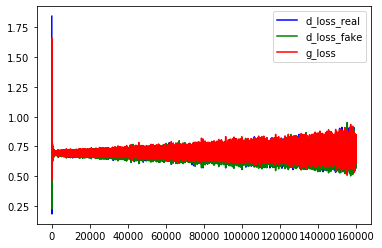

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3060, 0.8781]], device='cuda:0', grad_fn=<TanhBackward>)


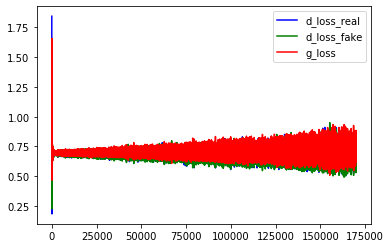

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3157, 0.8959]], device='cuda:0', grad_fn=<TanhBackward>)


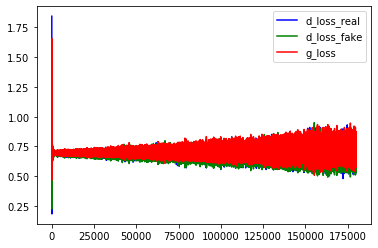

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3109, 0.8858]], device='cuda:0', grad_fn=<TanhBackward>)


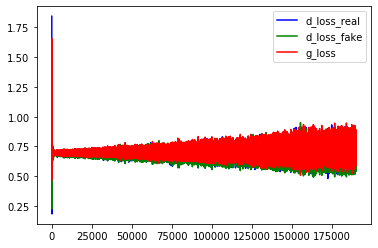

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3025, 0.8745]], device='cuda:0', grad_fn=<TanhBackward>)


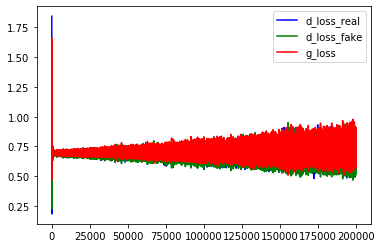

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3129, 0.8934]], device='cuda:0', grad_fn=<TanhBackward>)


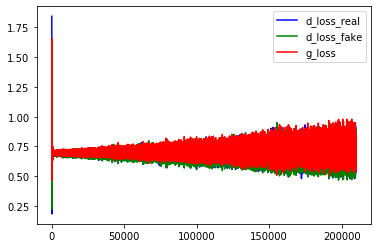

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3029, 0.8753]], device='cuda:0', grad_fn=<TanhBackward>)


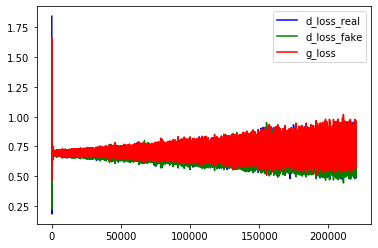

The current data point is tensor([[0.3089, 0.8845]], device='cuda:0', dtype=torch.float64)
The current prediction is tensor([[0.3143, 0.8943]], device='cuda:0', grad_fn=<TanhBackward>)


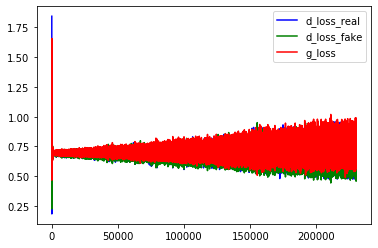

KeyboardInterrupt: ignored

In [47]:
dataset = ToyDataset(1, 2)

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1, 
                                           shuffle=True)

num_epochs = 1000000
train_gan(data_loader, D, G, num_epochs, data_dim, criterion, d_optimizer, g_optimizer, latent_size, hidden_size, batch_size, device, z_pool = True, z_pool_size = 1)